In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import seaborn as sns
import time

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, f1_score
from sklearn.metrics import classification_report, scorer, precision_score, recall_score

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.width', 4000)
pd.set_option('max_colwidth', 4000)
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

In [4]:
os.chdir('/Users/Weiyang/Desktop/Git/Assignment/Assignment3/Data')

In [5]:
dataset = pd.read_csv('telco-churn.csv', delimiter = ',')

### Inspecting Data

In [6]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
print ("Rows     : " ,dataset.shape[0])
print ("Columns  : " ,dataset.shape[1])
print ("\nFeatures : \n" ,dataset.columns.tolist())
print ("\nMissing values :  ", dataset.isnull().sum().values.sum())
print ("\nUnique values :  \n",dataset.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


### Data Manipulation

#### For Total Charges

In [8]:
dataset['TotalCharges'] = dataset["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
dataset = dataset[dataset["TotalCharges"].notnull()]
dataset = dataset.reset_index()[dataset.columns]

#convert to float type
dataset["TotalCharges"] = dataset["TotalCharges"].astype(float)

#### Re-Classifying No Internet Service to No

In [9]:
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_cols : 
    dataset[i]  = dataset[i].replace({'No internet service' : 'No'})
    
dataset["SeniorCitizen"] = dataset["SeniorCitizen"].replace({1:"Yes",0:"No"})

#### Seperating Churn and Non-Churn Customers

In [10]:
churn = dataset[dataset["Churn"] == "Yes"]
not_churn = dataset[dataset["Churn"] == "No"]

### Data Pre-Processing

#### Seperating into Categorical and Numerical Columns

In [11]:
Id_col = ['customerID']
target_col = ["Churn"]

#categorical columns
categorical_cols   = dataset.nunique()[dataset.nunique() < 6].keys().tolist()
categorical_cols   = [x for x in categorical_cols if x not in target_col]

#numerical columns
numerical_cols   = [x for x in dataset.columns if x not in categorical_cols + target_col + Id_col]

#Binary columns with 2 values
binary_cols   = dataset.nunique()[dataset.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_cols = [i for i in categorical_cols if i not in binary_cols]

#### Label Encoding Binary Columns

In [12]:
le = LabelEncoder()

for i in binary_cols :
    dataset[i] = le.fit_transform(dataset[i])

#### Dummy Variables for Multi-categorical Columns

In [13]:
dataset = pd.get_dummies(data = dataset,columns = multi_cols)

#### Scaling Numerical Values

In [14]:
std = MinMaxScaler()

scaled = std.fit_transform(dataset[numerical_cols])
scaled = pd.DataFrame(scaled,columns=numerical_cols)

#### Final Pre-processing

In [15]:
df_telcom = dataset.copy()

dataset = dataset.drop(numerical_cols,axis = 1)
dataset = dataset.merge(scaled,left_index=True,right_index=True,how = "left")

### Performing Random Sampling to cut down Dataset Size for Faster Processing

In [16]:
import random

In [17]:
dataset = dataset.sample(395)

##### This has been made the same size as the comparative Student Performance Dataset

In [18]:
dataset.shape

(395, 30)

### Seperating Data into Train & Test

In [19]:
y_labels = dataset.pop('Churn')

In [20]:
dataset = dataset.drop(['customerID'], axis=1)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(dataset, y_labels, test_size = 0.33, random_state = 777)

In [22]:
print(x_train.shape)

(264, 28)


In [23]:
print(y_train.shape)

(264,)


In [24]:
print(x_test.shape)

(131, 28)


In [25]:
print(y_test.shape)

(131,)


## k-Nearest Neighbors (With Feature Scaling)

In [26]:
model = KNeighborsClassifier(n_jobs = -1)

In [27]:
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
prediction = model.predict(x_test)

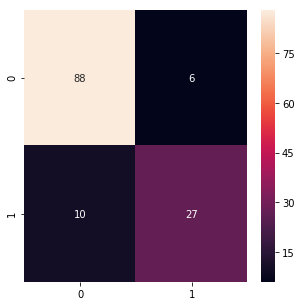

In [29]:
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

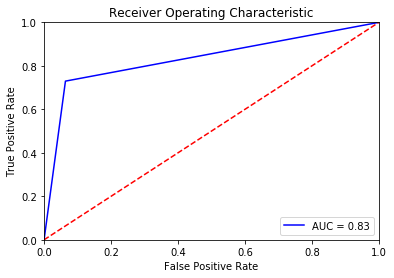

In [30]:
y_pred = model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_curve)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
score = round(accuracy_score(y_test, prediction),2)
print('Accuracy of Base Model: {} '.format(score))

Accuracy of Base Model: 0.88 


### Running Hyper-parameter Tuning to find Global Optimum

In [32]:
model = KNeighborsClassifier(n_jobs=-1)

In [33]:
k = np.arange(1,41)

In [34]:
params = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}

In [35]:
model1 = GridSearchCV(model, param_grid=params, n_jobs=1)

In [36]:
model1.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'leaf_size': [1, 2, 3, 5], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [37]:
print("Best Hyper Parameters:\n",model1.best_params_)

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 18, 'weights': 'uniform'}


In [38]:
prediction=model1.predict(x_test)

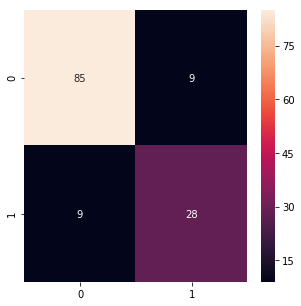

In [39]:
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

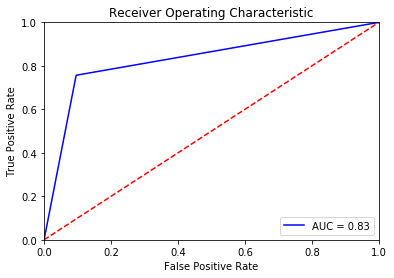

In [40]:
y_pred = model1.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_curve)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
score = round(accuracy_score(y_test, prediction),2)
print('Accuracy of Base Model: {} '.format(score))

Accuracy of Base Model: 0.86 


### Changing the Number of Neighbors

#### Using Mean Error as Metric

In [89]:
test_error = []
train_error = []

# Calculating error for K values between 1 and 40
for i in range(1, 41):  
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(x_train, y_train)
    knn_pred = model_knn.predict(x_train)
    train_error.append(np.mean(knn_pred != y_train))
    knn_pred = model_knn.predict(x_test)
    test_error.append(np.mean(knn_pred != y_test))

In [90]:
neighbors = pd.DataFrame()
neighbors['N_neighbors'] = list(range(1,41))
neighbors['Train_Error'] = train_error
neighbors['Test_Error'] = test_error

In [91]:
neighbors.set_index('N_neighbors')

,Train_Error,Test_Error
N_neighbors,,
1,0.000000,0.213740
2,0.125000,0.221374
3,0.166667,0.160305
4,0.178030,0.160305
5,0.208333,0.122137
6,0.189394,0.137405
7,0.208333,0.145038
8,0.189394,0.145038
9,0.212121,0.129771


In [92]:
print('The number of neighbors that gave the lowest error for Training is {}'.format((neighbors.loc[neighbors['Train_Error'].idxmin()][0])))
print('The number of neighbors that gave the lowest error for Testing is {}'.format((neighbors.loc[neighbors['Test_Error'].idxmin()][0])))

The number of neighbors that gave the lowest error for Training is 1.0
The number of neighbors that gave the lowest error for Testing is 5.0


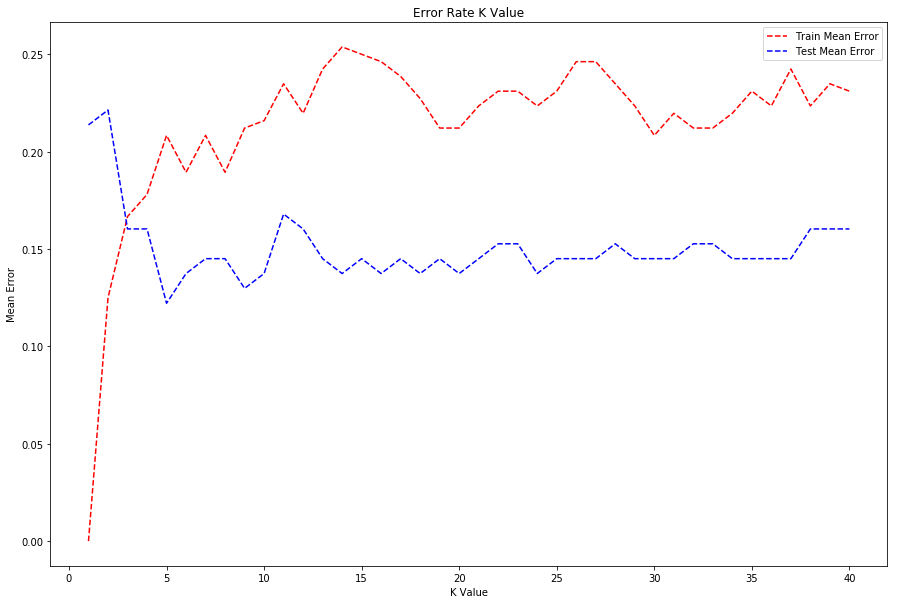

In [93]:
plt.figure(figsize=(15, 10))  
plt.plot(range(1, 41), train_error, color='red', linestyle='dashed',  
         markerfacecolor='red', markersize=10, label='Train Mean Error')
plt.plot(range(1, 41), test_error, color='blue', linestyle='dashed',  
         markerfacecolor='blue', markersize=10, label='Test Mean Error')
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')
plt.legend(loc='best')
plt.show()

#### The point where train mean error = test mean error is at 3 neighbors

#### Using AUC as metric

In [94]:
n_neighbors = list(range(1,41))

In [95]:
train_results = []
test_results = []

for n in n_neighbors:
   model = KNeighborsClassifier(n_neighbors=n)
   model.fit(x_train, y_train)
   train_pred = model.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   
   y_pred = model.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

In [96]:
neighbors['AUC_Train'] = train_results
neighbors['AUC_Test'] = test_results

In [98]:
neighbors.set_index('N_neighbors')

,Train_Error,Test_Error,AUC_Train,AUC_Test
N_neighbors,,,,
1,0.000000,0.213740,1.000000,0.752731
2,0.125000,0.221374,0.777027,0.640886
3,0.166667,0.160305,0.797582,0.781771
4,0.178030,0.160305,0.736060,0.748994
5,0.208333,0.122137,0.739758,0.832950
6,0.189394,0.137405,0.724040,0.797729
7,0.208333,0.145038,0.739758,0.816993
8,0.189394,0.145038,0.736415,0.792409
9,0.212121,0.129771,0.741252,0.835825


In [99]:
print('The number of neighbors that gave the highest AUC for Training is {}'.format((neighbors.loc[neighbors['AUC_Train'].idxmax()][0])))
print('The number of neighbors that gave the highest AUC for Testing is {}'.format((neighbors.loc[neighbors['AUC_Test'].idxmax()][0])))

The number of neighbors that gave the highest AUC for Training is 1.0
The number of neighbors that gave the highest AUC for Testing is 16.0


In [100]:
from matplotlib.legend_handler import HandlerLine2D

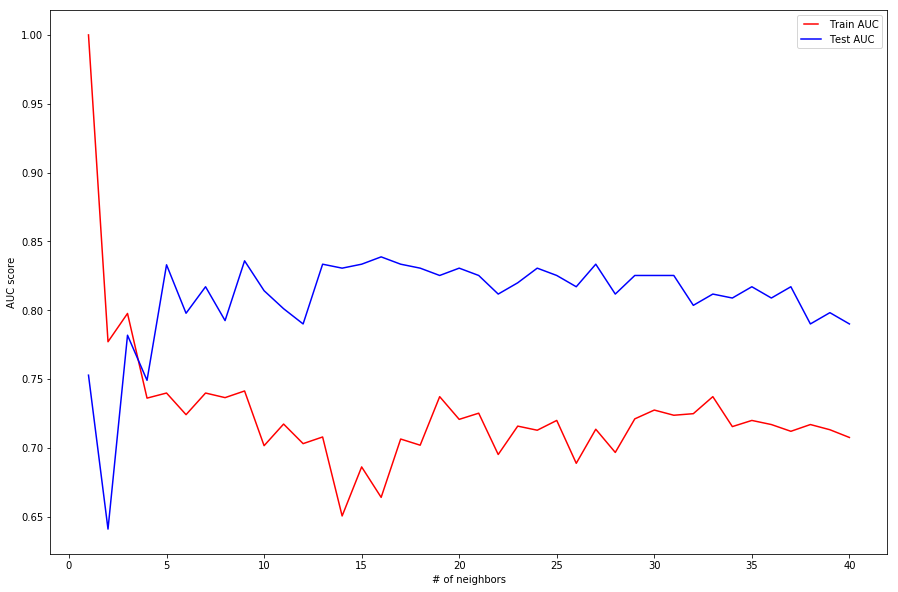

In [102]:
plt.figure(figsize=(15,10))

line1, = plt.plot(n_neighbors, train_results, 'r', label='Train AUC')
line2, = plt.plot(n_neighbors, test_results, 'b', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('# of neighbors')
plt.show()

### Changing Power parameter for the Minkowski metric 

#### Note: When p=1, this is equivalent to using manhattan_distance(l1), and euliddean_distance(l2) for p=2.

In [119]:
distances = [1,2,3,4,5]

In [120]:
train_distance = []
test_distance = []

for p in distances:
    
    model = KNeighborsClassifier(n_neighbors = 16, p=p)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_distance.append(roc_auc)
    
    test_pred = model.predict(x_test)
    fpr_test, tpr_test, thesholds_test = roc_curve(y_test, test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    test_distance.append(roc_auc_test)

In [123]:
minkowski_power = pd.DataFrame()
minkowski_power['Power'] = distances
minkowski_power['AUC_Train'] = train_distance
minkowski_power['AUC_Test'] = test_distance
minkowski_power.set_index('Power')

,AUC_Train,AUC_Test
Power,,
1,0.724751,0.811673
2,0.663940,0.838700
3,0.663940,0.838700
4,0.663940,0.825187
5,0.663940,0.825187


In [124]:
print('The power that gave the highest AUC for Training is {}'.format((minkowski_power.loc[minkowski_power['AUC_Train'].idxmax()][0])))
print('The power that gave the highest AUC for Testing is {}'.format((minkowski_power.loc[minkowski_power['AUC_Test'].idxmax()][0])))

The power that gave the highest AUC for Training is 1.0
The power that gave the highest AUC for Testing is 2.0


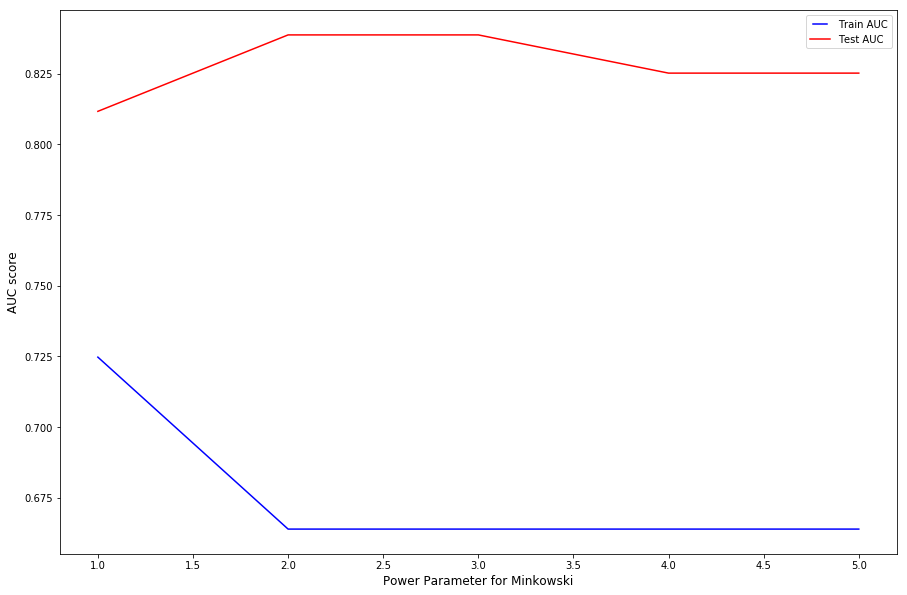

In [125]:
plt.figure(figsize=(15,10))

line1, = plt.plot(distances, train_distance, 'b', label = 'Train AUC')
line2, = plt.plot(distances, test_distance, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', size = 12)
plt.xlabel('Power Parameter for Minkowski', size = 12)
plt.show()

### Running Intermediate Model

In [126]:
model_int = KNeighborsClassifier(n_jobs=-1, n_neighbors = 16, p=2)

In [127]:
model_int.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

In [128]:
prediction=model_int.predict(x_test)

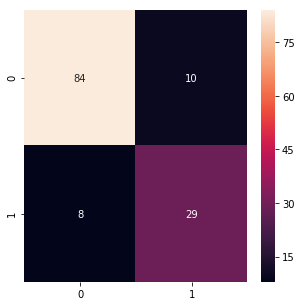

In [129]:
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize = (5,5))

sns.heatmap(cm, annot=True, fmt="d")

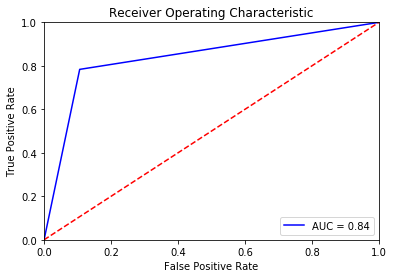

In [130]:
y_pred = model_int.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_curve)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [131]:
score = round(accuracy_score(y_test, prediction),2)
print('Accuracy of Base Model: {} '.format(score))

Accuracy of Base Model: 0.86 


### Changing Leaf Size

In [132]:
leaf_size = np.arange(1, 41)

In [139]:
train_leaf = []
test_leaf = []

for i in leaf_size:
    
    model = KNeighborsClassifier(n_neighbors = 16, p=2, leaf_size = i)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_leaf.append(roc_auc)
    
    test_pred = model.predict(x_test)
    fpr_test, tpr_test, thesholds_test = roc_curve(y_test, test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    test_leaf.append(roc_auc_test)

In [140]:
change_leaf = pd.DataFrame()
change_leaf['Leaf Size'] = leaf_size
change_leaf['AUC_Train'] = train_leaf
change_leaf['AUC_Test'] = test_leaf
change_leaf.set_index('Leaf Size')

,AUC_Train,AUC_Test
Leaf Size,,
1,0.66394,0.8387
2,0.66394,0.8387
3,0.66394,0.8387
4,0.66394,0.8387
5,0.66394,0.8387
6,0.66394,0.8387
7,0.66394,0.8387
8,0.66394,0.8387
9,0.66394,0.8387


In [141]:
print('The leaf size that gave the highest AUC for Training is {}'.format((change_leaf.loc[change_leaf['AUC_Train'].idxmax()][0])))
print('The leaf size that gave the highest AUC for Testing is {}'.format((change_leaf.loc[change_leaf['AUC_Test'].idxmax()][0])))

The leaf size that gave the highest AUC for Training is 1.0
The leaf size that gave the highest AUC for Testing is 1.0


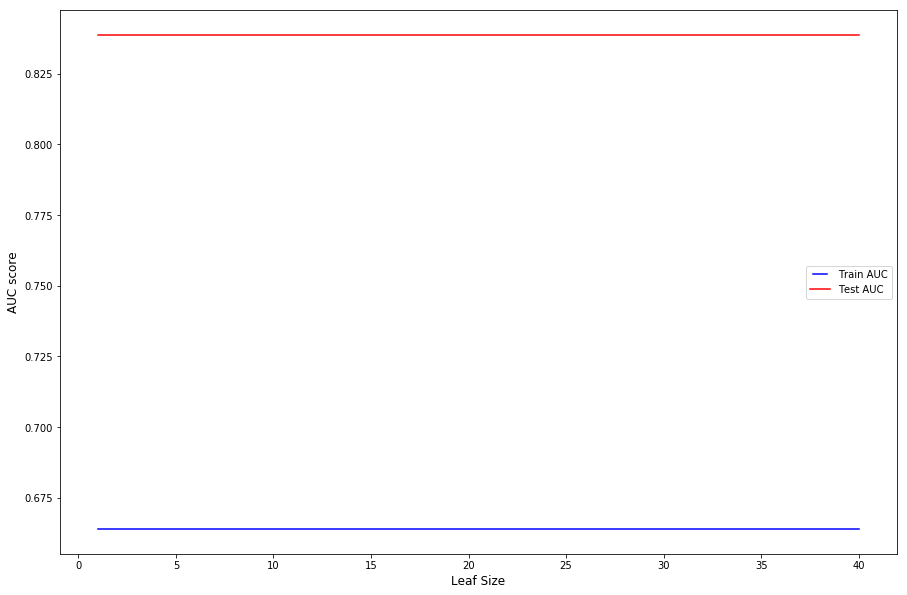

In [143]:
plt.figure(figsize=(15,10))

line1, = plt.plot(leaf_size, train_leaf, 'b', label = 'Train AUC')
line2, = plt.plot(leaf_size, test_leaf, 'r', label = 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score', size = 12)
plt.xlabel('Leaf Size', size = 12)
plt.show()

#### It would seem that leaf size does not affect the AUC for k-NN

### Changing Algorithms

In [144]:
algorithm_list = ['auto', 'ball_tree','kd_tree','brute']

In [146]:
train_algo = []
test_algo = []

for i in algorithm_list:
    
    model = KNeighborsClassifier(n_neighbors = 16, p=2, algorithm=i)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_algo.append(roc_auc)
    
    test_pred = model.predict(x_test)
    fpr_test, tpr_test, thesholds_test = roc_curve(y_test, test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    test_algo.append(roc_auc_test)

In [147]:
change_algorithm = pd.DataFrame()
change_algorithm['Algorithm'] = algorithm_list
change_algorithm['AUC_Train'] = train_algo
change_algorithm['AUC_Test'] = test_algo
change_algorithm.set_index('Algorithm')

,AUC_Train,AUC_Test
Algorithm,,
auto,0.66394,0.8387
ball_tree,0.66394,0.8387
kd_tree,0.66394,0.8387
brute,0.66394,0.8387


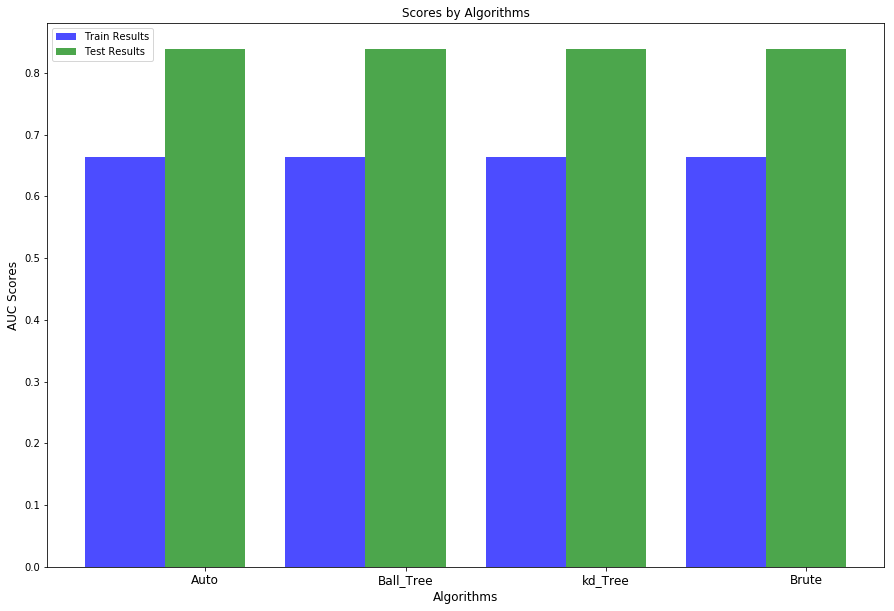

In [153]:
index = np.arange(len(algorithm_list))

fig, ax = plt.subplots(figsize=(15,10))
bar_width = 0.4
opacity = 0.7
 
rects1 = plt.bar(index, train_algo, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Train Results')
 
rects2 = plt.bar(index + bar_width, test_algo, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test Results')

 
plt.xlabel('Algorithms', size = 12)
plt.ylabel('AUC Scores', size = 12)
#plt.ylim(0.6,0.8)
plt.title('Scores by Algorithms')
plt.xticks(index + bar_width, ('Auto', 'Ball_Tree','kd_Tree','Brute'), size = 12)
plt.legend(loc='best')
 
plt.show()

#### It would seem changing Algorithms did not affect the AUC scores

### Changing Learning Size

In [181]:
size = np.linspace(0.1,1,100)

In [182]:
sample_size = x_train.shape[0]*size

In [183]:
training_space = []

for i in sample_size:
    training_space.append(int(i))

In [184]:
test_scores_1 = []
train_scores_1 = []

for i in training_space:

    x_new = x_train.iloc[:i,:]    
    y_new = y_train[:i]
    
    #Model Creation
    model = KNeighborsClassifier(n_neighbors = 16, p=2)
    model.fit(x_new, y_new)
    
    train_pred = model.predict(x_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_scores_1.append(roc_auc)
    
    test_pred = model.predict(x_test)
    fpr_test, tpr_test, thesholds_test = roc_curve(y_test, test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    test_scores_1.append(roc_auc_test)

In [185]:
change_ls = pd.DataFrame()
change_ls['Training Space'] = training_space
change_ls['AUC_Train'] = train_scores_1
change_ls['AUC_Test'] = test_scores_1
change_ls.set_index('Training Space')

,AUC_Train,AUC_Test
Training Space,,
26,0.500711,0.527027
28,0.505974,0.513514
31,0.514225,0.543416
33,0.612447,0.679413
36,0.666501,0.703997
38,0.567425,0.657706
40,0.633855,0.658137
43,0.686415,0.731024
45,0.679659,0.731024


In [186]:
print('The training size that gave the highest AUC for Training is {}'.format((change_ls.loc[change_ls['AUC_Train'].idxmax()][0])))
print('The training size that gave the highest AUC for Testing is {}'.format((change_ls.loc[change_ls['AUC_Test'].idxmax()][0])))

The training size that gave the highest AUC for Training is 81.0
The training size that gave the highest AUC for Testing is 244.0


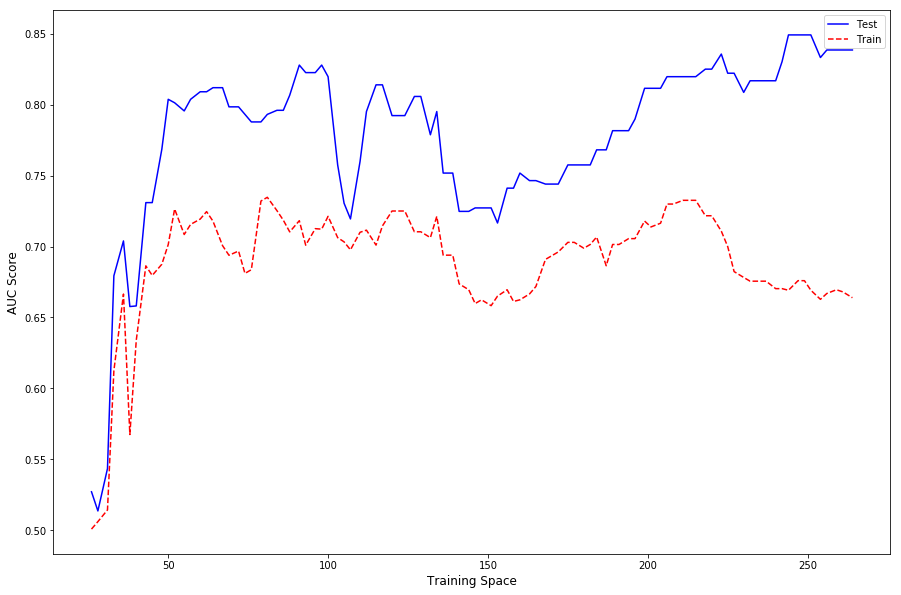

In [165]:
plt.figure(figsize=(15,10))

plt.plot(training_space, test_scores_1, 'b-', label='Test')
plt.plot(training_space, train_scores_1, 'r--', label='Train')

plt.legend(loc='best')
plt.xlabel('Training Space', size = 12)
plt.ylabel('AUC Score', size = 12)
plt.show()

In [166]:
model = KNeighborsClassifier(n_neighbors = 16, p=2)

In [167]:
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='uniform')

In [168]:
train_sizes, train_scores, test_scores = learning_curve(model, x_train, y_train, n_jobs=-1, cv=10, train_sizes=np.linspace(.1, 1.0, 100), verbose=0)

/Users/Weiyang/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


In [169]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

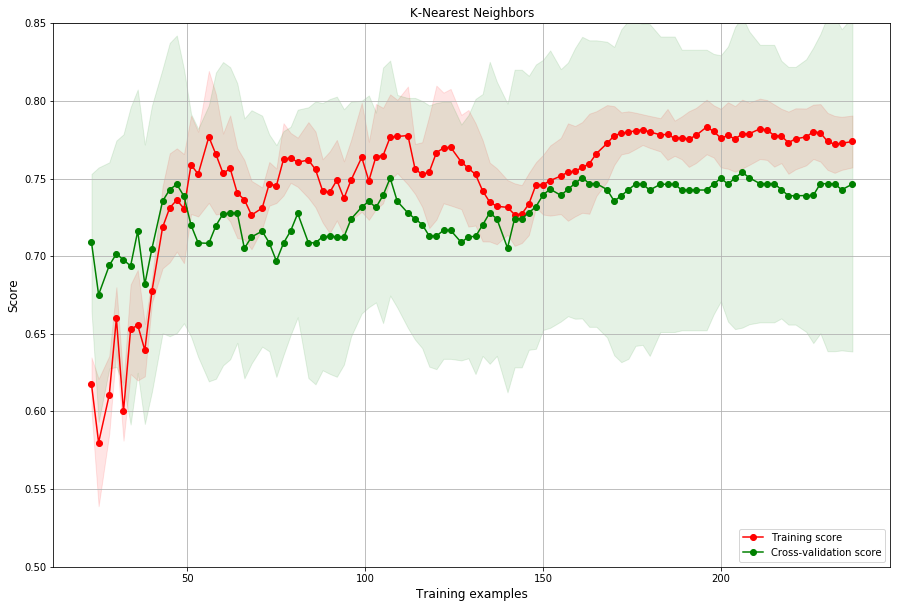

In [180]:
plt.figure(figsize=(15,10))
    
plt.grid()
    
# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label = 'Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label ="Cross-validation score")
    
# sizes the window for readability and displays the plot
# shows error from 0 to 1.1

plt.title("K-Nearest Neighbors")
plt.legend(loc = 'lower right')
plt.xlabel("Training examples", size =12)
plt.ylabel("Score", size = 12)
plt.ylim(0.5,0.85)
plt.show()

### Final Model

In [264]:
model_final = KNeighborsClassifier(n_jobs=-1, n_neighbors = 16, p=2)

In [265]:
x_new = x_train.iloc[:244,:]    
y_new = y_train[:244]

In [266]:
model_final.fit(x_new, y_new)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
           weights='uniform')

In [267]:
prediction=model_final.predict(x_test)

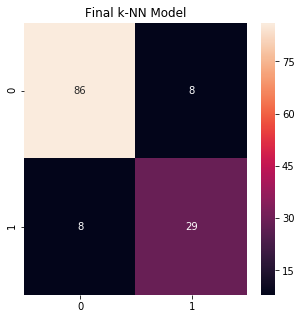

Sensitivity for k-NN:  0.915
Specificity for k-NN:  0.784
F Score for k-NN:  0.784


In [271]:
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize = (5,5))
plt.title('Final k-NN Model')
sns.heatmap(cm, annot=True, fmt="d")

plt.show()

sensitivity = round(cm[0,0]/(cm[0,0]+cm[0,1]),3)
print('Sensitivity for k-NN: ', sensitivity )
specificity = round(cm[1,1]/(cm[1,0]+cm[1,1]),3)
print('Specificity for k-NN: ', specificity)
f_score = round(f1_score(y_test, model_final.predict(x_test)),3)
print('F Score for k-NN: ', f_score)

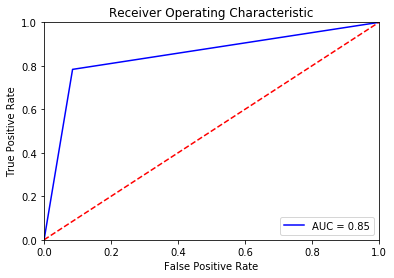

In [194]:
y_pred = model_final.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_curve)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [195]:
score = round(accuracy_score(y_test, prediction),2)
print('Accuracy of Base Model: {} '.format(score))

Accuracy of Base Model: 0.88 


### Visualizing Labels

In [196]:
from sklearn.decomposition import PCA

In [212]:
data1 = x_test.reset_index()

In [215]:
data1 = data1.drop(['index'], axis = 1)

In [216]:
data2 = pd.DataFrame(prediction)

In [221]:
visual_dataset = pd.concat([data1, data2], axis = 1)

In [224]:
visual_dataset.shape

(131, 29)

In [197]:
model_visuals = PCA(n_components = 3)

In [198]:
model_visuals.fit(x_test)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [200]:
X_3D = model_visuals.transform(x_test)

In [231]:
from mpl_toolkits.mplot3d import Axes3D

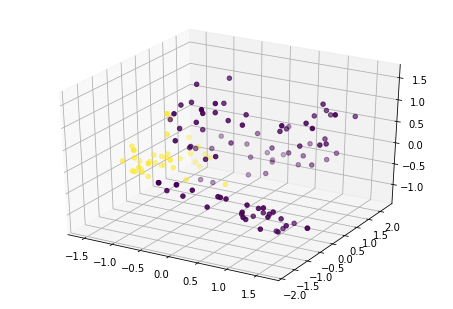

In [232]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(xs = X_3D[:,1], ys = X_3D[:,0], zs=X_3D[:,2], zdir='z', c = visual_dataset.iloc[:,28])
plt.show()

In [256]:
data11 = x_test.reset_index()
data11 = data11.drop(['index'], axis = 1)
data21 = pd.DataFrame(prediction).reset_index().drop(['index'], axis = 1)
data22 = pd.DataFrame(y_test).reset_index().drop(['index'], axis = 1)

visual_dataset1 = pd.concat([data11, data22, data21], axis = 1)

model_visuals1 = PCA(n_components = 2)
model_visuals1.fit(x_test)

X_2D = model_visuals1.transform(x_test)
X_2D = pd.DataFrame(X_2D)

In [258]:
visual_dataset1.columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure', 'MonthlyCharges', 'TotalCharges', 'actual', 'predicted']

In [259]:
visual_dataset1 = pd.concat([visual_dataset1, X_2D], axis = 1)

In [261]:
visual_dataset1.columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure', 'MonthlyCharges', 'TotalCharges', 'actual', 'predicted', 'PCA1', 'PCA2']

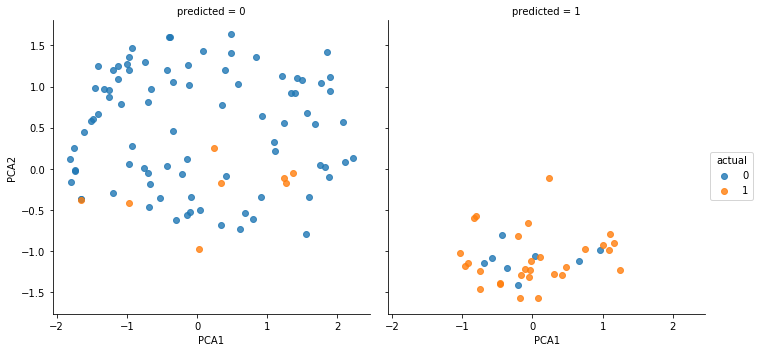

In [262]:
sns.lmplot('PCA1', 'PCA2', data=visual_dataset1, hue='actual',col='predicted', fit_reg=False, palette='tab10')